<a href="https://colab.research.google.com/github/jryuuu22/basketball-eclipse-project/blob/main/Copy_of_eclipse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basketball Eclipse Analytics Project

In [161]:
pip install optuna

In [162]:
"""
ft_pressure_final.py

Free Throw Pressure Model:
- Loads a pre-trained RandomForest model (final_rf.pkl)
- Provides FTPressurePredictor class for single + batch predictions
- Includes model evaluation + basic interpretability
- Ready for use in notebooks, scripts, or simple APIs for stakeholders
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from  typing import List, Dict, Union, Optional, Any
import kagglehub
import os
import re
import optuna
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    brier_score_loss,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc,
)

In [163]:
# Download / locate dataset
basketball = kagglehub.dataset_download("wyattowalsh/basketball")
csv_path = f"{basketball}/csv"
play_by_play_path = f"{csv_path}/play_by_play.csv"

print("CSV path:", play_by_play_path)
print("Files in cwd:", os.listdir())

Using Colab cache for faster access to the 'basketball' dataset.
CSV path: /kaggle/input/basketball/csv/play_by_play.csv
Files in cwd: ['.config', 'final_rf.pkl', 'imputer.pkl', '__pycache__', 'scaler.pkl', 'ft_pressure_final.py', 'y_test.csv', 'X_test_raw.csv', 'sample_data']


In [164]:
code = """
import re
import pandas as pd
import numpy as np
import pickle
from typing import Optional, Union

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    brier_score_loss,
)

FEATURE_COLS = [
    'season_FT_pct',
    'overall_ft_pct',
    'career_attempts_so_far',
    'period',
    'seconds_remaining',
    'is_clutch',
    'close_game',
    'late_game',
    'pressure_score',
    'point_differential',
]


def prepare_ft_dataset(
    play_by_play_path: str,
    nrows: Optional[int] = None,
) -> pd.DataFrame:
    \"\"\"Minimal feature-engineering pipeline from raw play_by_play.csv.

    Returns a DataFrame with FEATURE_COLS + ['FT_made', 'game_id'].
    \"\"\"

    df = pd.read_csv(play_by_play_path, nrows=nrows)

    # Keep only free throw events
    keyword = "Free Throw"
    filtered_df = df[
        df[["homedescription", "visitordescription"]]
        .apply(lambda x: x.astype(str).str.contains(keyword, case=False, na=False))
        .any(axis=1)
    ]

    # Drop unused columns if present
    filtered_df = filtered_df.drop(
        columns=[
            'neutraldescription', 'video_available_flag',
            'person1type','player1_team_nickname','player1_team_abbreviation',
            'player1_id','player1_name','player1_team_city','player1_team_id',
            'person2type','player2_team_nickname','player2_team_abbreviation',
            'player2_id','player2_name','player2_team_city','player2_team_id',
            'person3type','player3_team_nickname','player3_team_abbreviation',
            'player3_id','player3_name','player3_team_city','player3_team_id',
        ],
        errors='ignore'
    )

    # Merge descriptions into FT_Event
    nan_idx = filtered_df[filtered_df['homedescription'].isna()].index
    filtered_df.loc[nan_idx, 'homedescription'] = filtered_df.loc[nan_idx, 'visitordescription']
    filtered_df = filtered_df.drop(columns=['visitordescription'], errors='ignore')
    filtered_df = filtered_df.rename(columns={'homedescription': 'FT_Event'})

    # --- NEW: extract player_name from FT_Event ---
    def extract_player_name(desc):
        if pd.isna(desc):
            return None
        m = re.search(r'^(?:MISS\\s+)?([A-Za-z\\.\\s]+?)\\s+Free Throw', str(desc))
        return m.group(1).strip() if m else None

    filtered_df['player_name'] = filtered_df['FT_Event'].apply(extract_player_name)

    # Target: make vs miss
    missed_mask = filtered_df['FT_Event'].str.contains('MISS', case=False, na=False)
    filtered_df['FT_made'] = (~missed_mask).astype(int)

    # Fix score: sort then forward-fill
    filtered_df = filtered_df.sort_values(['game_id', 'period', 'eventnum'])
    filtered_df['score'] = filtered_df.groupby('game_id')['score'].ffill()
    filtered_df = filtered_df.dropna(subset=['score'])

    # Parse score -> home/away + point diff
    score_clean = filtered_df['score'].str.replace(' ', '')
    filtered_df['home_score'] = score_clean.str.split('-').str[0].astype(int)
    filtered_df['away_score'] = score_clean.str.split('-').str[1].astype(int)
    filtered_df['point_differential'] = (
        (filtered_df['home_score'] - filtered_df['away_score']).abs()
    )

    # Time (MM:SS) -> seconds
    def time_to_seconds(t):
        if pd.isna(t):
            return None
        mm, ss = str(t).split(':')
        return int(mm) * 60 + int(ss)

    filtered_df['seconds_remaining'] = filtered_df['pctimestring'].apply(time_to_seconds)

    # Pressure flags
    filtered_df['is_clutch'] = (
        (filtered_df['period'] >= 4) &
        (filtered_df['seconds_remaining'] <= 300)
    ).astype(int)

    filtered_df['close_game'] = (filtered_df['point_differential'] <= 3).astype(int)
    filtered_df['late_game'] = (filtered_df['period'] >= 4).astype(int)

    filtered_df['pressure_score'] = (
        filtered_df['is_clutch']
        + filtered_df['close_game']
        + (filtered_df['seconds_remaining'] <= 120).astype(int)
    )

    # Season FT%
    season_ft = (
        filtered_df.groupby('player_name')['FT_made']
        .mean()
        .reset_index()
        .rename(columns={'FT_made': 'season_FT_pct'})
    )
    filtered_df = filtered_df.merge(season_ft, on='player_name', how='left')

    # Overall FT% + attempts
    player_stats = (
        filtered_df.groupby('player_name')['FT_made']
        .agg(['count', 'mean'])
        .reset_index()
    )
    player_stats.columns = ['player_name', 'career_attempts_so_far', 'overall_ft_pct']
    filtered_df = filtered_df.merge(player_stats, on='player_name', how='left')

    # Final frame
    model_df = filtered_df[FEATURE_COLS + ['FT_made', 'game_id']].dropna()
    return model_df


def train_and_save_model(
    play_by_play_path: str,
    nrows: Optional[int] = None,
    model_path: str = 'final_rf.pkl',
    imputer_path: str = 'imputer.pkl',
    scaler_path: str = 'scaler.pkl',
):
    \"\"\"Train RF, save model + preprocessors, return training metrics.\"\"\"
    model_df = prepare_ft_dataset(play_by_play_path, nrows=nrows)

    X = model_df[FEATURE_COLS]
    y = model_df['FT_made']

    imputer = SimpleImputer(strategy='median')
    X_imp = imputer.fit_transform(X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imp)

    model = RandomForestClassifier(
        n_estimators=188,
        max_depth=4,
        min_samples_split=6,
        min_samples_leaf=11,
        max_features='log2',
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_scaled, y)

    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    with open(imputer_path, 'wb') as f:
        pickle.dump(imputer, f)
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    y_proba = model.predict_proba(X_scaled)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    metrics = {
        'accuracy': float(accuracy_score(y, y_pred)),
        'pr_auc': float(average_precision_score(y, y_proba)),
        'brier': float(brier_score_loss(y, y_proba)),
    }
    return metrics


class FTPressurePredictor:
    \"\"\"Wrapper around the trained RF model for single/batch predictions.\"\"\"

    def __init__(
        self,
        model_path: str = 'final_rf.pkl',
        imputer_path: str = 'imputer.pkl',
        scaler_path: str = 'scaler.pkl',
    ):
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)
        with open(imputer_path, 'rb') as f:
            self.imputer = pickle.load(f)
        with open(scaler_path, 'rb') as f:
            self.scaler = pickle.load(f)

        self.feature_cols = FEATURE_COLS

    def _to_frame(self, X: Union[dict, pd.Series, pd.DataFrame]) -> pd.DataFrame:
        if isinstance(X, dict):
            df = pd.DataFrame([X])
        elif isinstance(X, pd.Series):
            df = X.to_frame().T
        elif isinstance(X, pd.DataFrame):
            df = X.copy()
        else:
            raise TypeError("X must be dict, Series, or DataFrame")
        return df[self.feature_cols]

    def predict_proba(self, X: Union[dict, pd.Series, pd.DataFrame]) -> np.ndarray:
        df = self._to_frame(X)
        X_imp = self.imputer.transform(df)
        X_scaled = self.scaler.transform(X_imp)
        return self.model.predict_proba(X_scaled)[:, 1]

    def predict(self, X: Union[dict, pd.Series, pd.DataFrame], threshold: float = 0.5) -> np.ndarray:
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)


def evaluate_model(
    predictor: FTPressurePredictor,
    X: pd.DataFrame,
    y: pd.Series,
    threshold: float = 0.5,
):
    \"\"\"Evaluate a trained predictor on X, y and return metrics.\"\"\"
    y_proba = predictor.predict_proba(X)
    y_pred = (y_proba >= threshold).astype(int)

    return {
        'accuracy': float(accuracy_score(y, y_pred)),
        'pr_auc': float(average_precision_score(y, y_proba)),
        'brier': float(brier_score_loss(y, y_proba)),
    }
"""

with open("ft_pressure_final.py", "w") as f:
    f.write(code)

print("✅ ft_pressure_final.py rewritten with player_name extraction")


✅ ft_pressure_final.py rewritten with player_name extraction


In [165]:
# This cell was removed as its content is redundant and caused conflicts with the main evaluate_model function.

In [166]:
FEATURE_COLS: List[str] = [
    "season_FT_pct",
    "overall_ft_pct",
    "clutch_ft_pct",
    "clutch_factor",
    "career_attempts_so_far",
    "period",
    "seconds_remaining",
    "is_clutch",
    "close_game",
    "late_game",
    "pressure_score",
    "point_differential",
]

# Best RF params copied from Optuna run
BEST_RF_PARAMS = {
    "n_estimators": 188,
    "max_depth": 4,
    "min_samples_split": 6,
    "min_samples_leaf": 11,
    "max_features": "log2",
    "random_state": 42,
    "n_jobs": -1,
}

In [167]:
basketball = kagglehub.dataset_download("wyattowalsh/basketball")
csv_path = f"{basketball}/csv"
#load dataframe from play_by_play csv
df = pd.read_csv(
    f"{csv_path}/play_by_play.csv", nrows=100000
)

Using Colab cache for faster access to the 'basketball' dataset.


Data Cleaning

In [168]:
def prepare_ft_dataset_from_df(
    input_df: pd.DataFrame,
) -> pd.DataFrame:
  """
  Feature engineering pipeline from raw play_by_play.csv.

  Function cleaning dataset and preparing it for EDA.

  Parameters
  ----------
  input_df : pd.DataFrame
    The input DataFrame containing play-by-play data.

  Returns
  -------
  model_df : DataFrame
      Contains FEATURE_COLS + ['FT_made', 'game_id'].
  """
  filtered_df = input_df.copy()

  #filter event by free throw
  keyword = "Free Throw"
  filtered_df = filtered_df[
      filtered_df[["homedescription", "visitordescription"]]
      .apply(lambda x: x.astype(str).str.contains(keyword, case=False, na=False))
      .any(axis=1)
  ]

  # Drop unused columns
  filtered_df = filtered_df.drop(columns=[
      'neutraldescription', 'video_available_flag',
      'person1type','player1_team_nickname', 'player1_team_abbreviation', 'player1_id', 'player1_name', 'player1_team_city', 'player1_team_id',
      'person2type','player2_team_nickname', 'player2_team_abbreviation', 'player2_id', 'player2_name', 'player2_team_city', 'player2_team_id',
      'person3type','player3_team_nickname', 'player3_team_abbreviation', 'player3_id', 'player3_name', 'player3_team_city', 'player3_team_id'])

  # Combine the home description and visitor description to one index
  nan_indices = filtered_df[filtered_df['homedescription'].isna()].index
  filtered_df.loc[nan_indices,'homedescription'] = filtered_df.loc[nan_indices,'visitordescription']

  # Drop unnneeded column
  filtered_df = filtered_df.drop(columns=['visitordescription'])

  # Rename homedescription with better description
  filtered_df.rename(columns={'homedescription': 'FT_Event'}, inplace=True)

  # Check whether each FT attempt is a miss
  missed_ft_mask = filtered_df['FT_Event'].str.contains('MISS', case=False, na=False)

  filtered_df.loc[:, 'FT_made'] = (~missed_ft_mask).astype(int)
  # Create a function to replace Na value in score index
  filtered_df = filtered_df.sort_values(['game_id', 'period', 'eventnum'])
  filtered_df['score'] = (
      filtered_df.groupby('game_id')['score']
      .ffill()
  )
  # With the remaining, we will drop as 93 is insufficient compared to 11k
  filtered_df = filtered_df.dropna(subset=['score'])

  # Clean up the score string and split into home / away
  score_clean = filtered_df['score'].str.replace(' ', '')

  filtered_df['home_score'] = score_clean.str.split('-').str[0].astype(int)
  filtered_df['away_score'] = score_clean.str.split('-').str[1].astype(int)

  # Define margin as home - away (or away - home if you prefer)
  filtered_df['scoremargin'] = filtered_df['home_score'] - filtered_df['away_score']

  # Player name extraction
  def extract_player_name(description: Any) -> Optional[str]:
      if pd.isna(description):
          return None
      match = re.search(r"^(?:MISS\s+)?([A-Za-z\.\s]+?)\s+Free Throw", str(description))
      return match.group(1).strip() if match else None

  filtered_df["player_name"] = filtered_df["FT_Event"].apply(extract_player_name)

  # Time remaining in period (seconds)
  def time_to_seconds(time_str: Any) -> Optional[int]:
      if pd.isna(time_str):
          return None
      try:
          parts = str(time_str).split(":")
          return int(parts[0]) * 60 + int(parts[1])
      except Exception:
          return None

  filtered_df["seconds_remaining"] = filtered_df["pctimestring"].apply(time_to_seconds)

  # Clutch = last 5 minutes of 4th or OT
  filtered_df["is_clutch"] = (
      (filtered_df["period"] >= 4) & (filtered_df["seconds_remaining"] <= 300)
  ).astype(int)

  # Point differential (absolute)
  def parse_score_diff(score_str: Any) -> Optional[int]:
      if pd.isna(score_str):
          return None
      try:
          home, away = score_str.split(" - ")
          return abs(int(home) - int(away))
      except Exception:
          return None

  filtered_df["point_differential"] = filtered_df["score"].apply(parse_score_diff)

  # High pressure = clutch + within 5 points
  filtered_df["high_pressure"] = (
      (filtered_df["is_clutch"] == 1) & (filtered_df["point_differential"] <= 5)
  ).astype(int)

  # --- Player-level aggregates

  # Season FT% per player (in this dataset)
  season_ft = (
      filtered_df.groupby("player_name")["FT_made"]
      .mean()
      .reset_index()
      .rename(columns={"FT_made": "season_FT_pct"})
  )
  filtered_df = filtered_df.merge(season_ft, on="player_name", how="left")

  # Overall FT%, clutch attempts, etc.
  player_stats = (
      filtered_df.groupby("player_name")
      .agg(
          {
              "FT_made": ["sum", "count", "mean"],
              "is_clutch": "sum",
              "high_pressure": "sum",
          }
      )
      .reset_index()
  )
  player_stats.columns = [
      "player_name",
      "ft_made_total",
      "ft_attempts",
      "overall_ft_pct",
      "clutch_attempts",
      "high_pressure_attempts",
  ]

  clutch_stats = (
      filtered_df[filtered_df["is_clutch"] == 1]
      .groupby("player_name")["FT_made"]
      .mean()
      .reset_index()
      .rename(columns={"FT_made": "clutch_ft_pct"})
  )

  high_pressure_stats = (
      filtered_df[filtered_df["high_pressure"] == 1]
      .groupby("player_name")["FT_made"]
      .mean()
      .reset_index()
      .rename(columns={"FT_made": "high_pressure_ft_pct"})
  )

  player_stats = player_stats.merge(clutch_stats, on="player_name", how="left")
  player_stats = player_stats.merge(high_pressure_stats, on="player_name", how="left")
  player_stats["clutch_factor"] = (
      player_stats["clutch_ft_pct"] - player_stats["overall_ft_pct"]
  )

  # Merge player-level stats back to events
  filtered_df = filtered_df.merge(
      player_stats[["player_name", "overall_ft_pct", "clutch_ft_pct", "clutch_factor"]],
      on="player_name",
      how="left",
  )

  # Additional context flags
  filtered_df["close_game"] = (filtered_df["point_differential"] <= 3).astype(int)
  filtered_df["late_game"] = (filtered_df["period"] >= 4).astype(int)
  filtered_df["pressure_score"] = (
      filtered_df["is_clutch"].astype(int)
      + filtered_df["close_game"].astype(int)
      + (filtered_df["seconds_remaining"] <= 120).astype(int)
  )

  # Career attempts so far (within this dataset)
  career_attempts = filtered_df.groupby("player_name").size().to_dict()
  filtered_df["career_attempts_so_far"] = filtered_df["player_name"].map(
      career_attempts
  )

  # Final modeling frame
  model_df = filtered_df[FEATURE_COLS + ["FT_made", "game_id"]].copy()
  model_df = model_df.dropna(subset=["FT_made", "game_id"])

  return model_df

In [169]:
filtered_df = prepare_ft_dataset_from_df(df)

Simple EDA

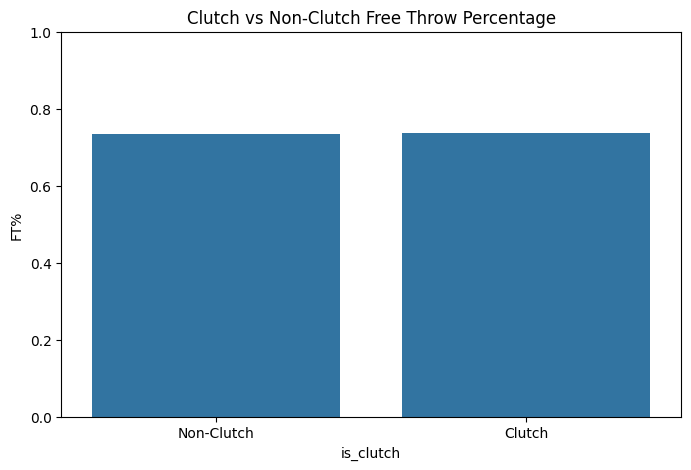

In [170]:
#Cluth vs Non-Clutch FT%
clutch_ft = filtered_df.groupby('is_clutch')['FT_made'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=clutch_ft, x='is_clutch', y='FT_made')
plt.title("Clutch vs Non-Clutch Free Throw Percentage")
plt.xticks([0,1], ['Non-Clutch', 'Clutch'])
plt.ylabel("FT%")
plt.ylim(0, 1)
plt.show()

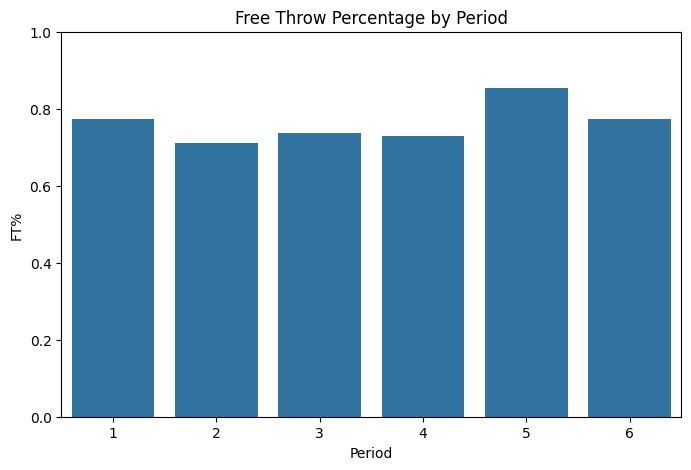

In [171]:
period_ft = filtered_df.groupby('period')['FT_made'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=period_ft, x='period', y='FT_made')
plt.title("Free Throw Percentage by Period")
plt.ylabel("FT%")
plt.xlabel("Period")
plt.ylim(0, 1)
plt.show()

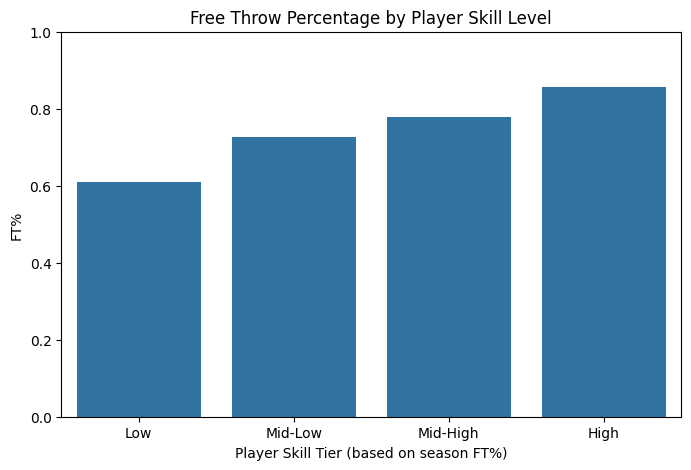

In [172]:
df_skill = filtered_df.dropna(subset=['season_FT_pct']).copy()

# Create skill tier buckets using quartiles
df_skill['skill_bucket'] = pd.qcut(
    df_skill['season_FT_pct'],
    q=4,
    labels=['Low', 'Mid-Low', 'Mid-High', 'High']
)

# Compute FT% within each bucket
skill_ft = (
    df_skill.groupby('skill_bucket',observed=True)['FT_made']
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=skill_ft, x='skill_bucket', y='FT_made')

plt.title("Free Throw Percentage by Player Skill Level")
plt.xlabel("Player Skill Tier (based on season FT%)")
plt.ylabel("FT%")
plt.ylim(0, 1)

plt.show()

Pressure score distribution:
pressure_score
0    4901
1    4211
2    1861
3     312
Name: count, dtype: int64


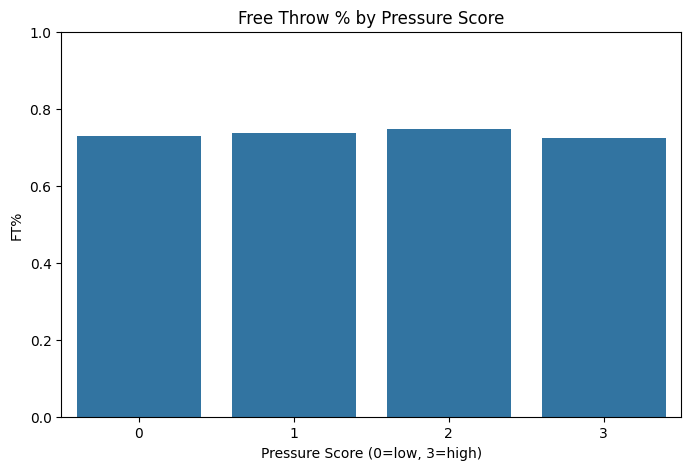

In [173]:
filtered_df['pressure_score'] = (
    filtered_df['is_clutch'].astype(int) +
    filtered_df['close_game'].astype(int) +
    (filtered_df['seconds_remaining'] <= 120).astype(int)
)
# Score of 3 = clutch time + close game + under 2 minutes (maximum pressure)
# Score of 0 = none of these factors (low pressure)
print("Pressure score distribution:")
print(filtered_df['pressure_score'].value_counts().sort_index())
pressure_performance = filtered_df.groupby('pressure_score')['FT_made'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=pressure_performance, x='pressure_score', y='FT_made')
plt.title("Free Throw % by Pressure Score")
plt.xlabel("Pressure Score (0=low, 3=high)")
plt.ylabel("FT%")
plt.ylim(0, 1)
plt.show()

Train model and saving model

In [174]:
def train_and_save_model(
    play_by_play_path: str,
    nrows: Optional[int] = None,
    test_size: float = 0.2,
) -> Dict[str, float]:
    """
    End-to-end training from raw play_by_play.csv.

    Steps:
    - Build features via prepare_ft_dataset_from_df
    - Game-level train/test split
    - Fit imputer + scaler on train
    - Train RandomForest with BEST_RF_PARAMS
    - Evaluate on test
    - Save: final_rf.pkl, imputer.pkl, scaler.pkl, X_test_raw.csv, y_test.csv

    Returns
    -------
    metrics : dict
        Contains accuracy, pr_auc, brier.
    """
    # Load raw data
    raw_df = pd.read_csv(play_by_play_path, nrows=nrows)
    model_df = prepare_ft_dataset_from_df(raw_df)

    X = model_df[FEATURE_COLS].copy()
    y = model_df["FT_made"].astype(int).copy()
    game_ids = model_df["game_id"].unique()

    # Game-level split (same logic as notebook)
    train_games, test_games = train_test_split(
        game_ids, test_size=test_size, shuffle=False
    )
    train_mask = model_df["game_id"].isin(train_games)
    test_mask = model_df["game_id"].isin(test_games)

    X_train_raw = X[train_mask].copy()
    X_test_raw = X[test_mask].copy()
    y_train = y[train_mask].copy()
    y_test = y[test_mask].copy()

    # Preprocessing: impute + scale
    imputer = SimpleImputer(strategy="median")
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train_raw),
        columns=FEATURE_COLS,
        index=X_train_raw.index,
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test_raw),
        columns=FEATURE_COLS,
        index=X_test_raw.index,
    )

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_imputed),
        columns=FEATURE_COLS,
        index=X_train_imputed.index,
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_imputed),
        columns=FEATURE_COLS,
        index=X_test_imputed.index,
    )

    # Model: RandomForest with pre-tuned params
    model = RandomForestClassifier(**BEST_RF_PARAMS)
    model.fit(X_train_scaled, y_train)

    # Test metrics
    y_proba_test = model.predict_proba(X_test_scaled)[:, 1]
    y_pred_test = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred_test)
    pr_auc = average_precision_score(y_test, y_proba_test)
    brier = brier_score_loss(y_test, y_proba_test)

    print("=== Test Performance (from train_and_save_model) ===")
    print(f"Accuracy   : {acc:.4f}")
    print(f"PR-AUC     : {pr_auc:.4f}")
    print(f"Brier score: {brier:.4f}")

    # Save raw test features and labels (for later evaluation with full pipeline)
    X_test_raw.to_csv("X_test_raw.csv", index=False)
    y_test.to_csv("y_test.csv", index=False)

    # Save model + preprocessing
    with open("final_rf.pkl", "wb") as f:
        pickle.dump(model, f)
    with open("imputer.pkl", "wb") as f:
        pickle.dump(imputer, f)
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

    return {"accuracy": acc, "pr_auc": pr_auc, "brier": brier}

Predictor Class

In [175]:
class PredictionExplanation:
    """Structured explanation for one prediction."""
    prob_make: float
    predicted_label: int
    top_factors: List[Dict[str, Any]]  # [{feature, contribution_pct, value}, ...]


class FTPressurePredictor:
    """
    Loads:
    - final_rf.pkl
    - imputer.pkl
    - scaler.pkl

    Accepts DataFrames/dicts with *raw* feature columns (FEATURE_COLS),
    applies the same imputer + scaler, and returns probabilities / labels.

    Also supports simple per-shot explanations based on feature_importances_
    and the (scaled) feature values.
    """

    def __init__(
        self,
        model_path: str = "final_rf.pkl",
        imputer_path: str = "imputer.pkl",
        scaler_path: str = "scaler.pkl",
        feature_cols: Optional[List[str]] = None,
    ) -> None:
        self.feature_cols = feature_cols or FEATURE_COLS

        with open(model_path, "rb") as f:
            self.model = pickle.load(f)
        with open(imputer_path, "rb") as f:
            self.imputer = pickle.load(f)
        with open(scaler_path, "rb") as f:
            self.scaler = pickle.load(f)

        if not hasattr(self.model, "feature_importances_"):
            raise ValueError(
                "Loaded model does not expose feature_importances_. "
                "This class expects a tree-based model like RandomForest."
            )

        if len(self.model.feature_importances_) != len(self.feature_cols):
            raise ValueError(
                "Feature length mismatch between model and FEATURE_COLS. "
                "Check that your training and inference configs align."
            )

    # ---------- Internal helpers ----------
    def _to_dataframe_raw(
        self,
        X: Union[Dict[str, float], pd.Series, pd.DataFrame],
    ) -> pd.DataFrame:
        """Coerce input into a DataFrame with the correct column order."""
        if isinstance(X, dict):
            df = pd.DataFrame([X])
        elif isinstance(X, pd.Series):
            df = X.to_frame().T
        elif isinstance(X, pd.DataFrame):
            df = X.copy()
        else:
            raise TypeError("X must be a dict, pandas Series, or pandas DataFrame.")

        missing = [c for c in self.feature_cols if c not in df.columns]
        if missing:
            raise ValueError(f"Missing required feature(s): {missing}")

        df = df[self.feature_cols]
        df = df.apply(pd.to_numeric, errors="coerce")

        if df.isna().any().any():
            raise ValueError(
                "NaNs detected in features after coercion to numeric. "
                "Make sure all features are present and numeric."
            )

        return df

    def _prepare_for_model(self, X_raw: pd.DataFrame) -> pd.DataFrame:
        """Apply the saved imputer + scaler."""
        X_imp = pd.DataFrame(
            self.imputer.transform(X_raw),
            columns=self.feature_cols,
            index=X_raw.index,
        )
        X_scaled = pd.DataFrame(
            self.scaler.transform(X_imp),
            columns=self.feature_cols,
            index=X_imp.index,
        )
        return X_scaled

    # ---------- Public prediction API ----------
    def predict_proba(
        self,
        X: Union[Dict[str, float], pd.Series, pd.DataFrame],
    ) -> np.ndarray:
        """
        Predict P(FT make) for one or more rows of *raw* features.

        Returns
        -------
        probs : np.ndarray of shape (n_samples,)
        """
        df_raw = self._to_dataframe_raw(X)
        X_scaled = self._prepare_for_model(df_raw)
        probs = self.model.predict_proba(X_scaled)[:, 1]
        return probs

    def predict(
        self,
        X: Union[Dict[str, float], pd.Series, pd.DataFrame],
        threshold: float = 0.5,
    ) -> np.ndarray:
        """
        Predict binary outcome (1 = make, 0 = miss) using a probability threshold.
        """
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

    def predict_single_with_explanation(
        self,
        X: Union[Dict[str, float], pd.Series],
        threshold: float = 0.5,
        top_k: int = 3,
    ) -> PredictionExplanation:
        """
        Single-shot prediction with a simple explanation.

        Explanation logic:
        - Use feature_importances_ as global weights.
        - Scale them by the absolute value of the (scaled) feature values for this shot.
        - Normalize to get % contributions and return the top_k factors.
        """
        df_raw = self._to_dataframe_raw(X)
        if len(df_raw) != 1:
            raise ValueError("predict_single_with_explanation expects exactly one row.")

        X_scaled = self._prepare_for_model(df_raw)

        prob_make = float(self.predict_proba(df_raw)[0])
        predicted_label = int(prob_make >= threshold)

        fi_raw = np.array(self.model.feature_importances_, dtype=float)
        fi_raw = np.maximum(fi_raw, 0.0)

        row_values = X_scaled.iloc[0].values.astype(float)
        contrib_scores = np.abs(row_values) * fi_raw
        total_score = contrib_scores.sum()
        if total_score <= 0:
            contrib_scores = fi_raw
            total_score = contrib_scores.sum() if contrib_scores.sum() > 0 else 1.0

        contrib_pct = (contrib_scores / total_score) * 100.0

        contrib_df = pd.DataFrame(
            {
                "feature": self.feature_cols,
                "value": row_values,
                "contribution_pct": contrib_pct,
            }
        ).sort_values("contribution_pct", ascending=False)

        top = contrib_df.head(top_k)
        top_factors = [
            {
                "feature": r["feature"],
                "value": float(r["value"]),
                "contribution_pct": float(r["contribution_pct"]),
            }
            for _, r in top.iterrows()
        ]

        return PredictionExplanation(
            prob_make=prob_make,
            predicted_label=predicted_label,
            top_factors=top_factors,
        )

    def feature_importances(self) -> pd.DataFrame:
        """Return global feature importances as a tidy DataFrame."""
        fi = np.array(self.model.feature_importances_, dtype=float)
        total = fi.sum() if fi.sum() > 0 else 1.0
        pct = (fi / total) * 100.0
        return (
            pd.DataFrame(
                {"feature": self.feature_cols, "importance": fi, "importance_pct": pct}
            )
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )


Evaluation and simple EDA Helpers

In [176]:
def evaluate_model(
    predictor: FTPressurePredictor,
    X_test_path: str = "X_test_raw.csv",
    y_test_path: str = "y_test.csv",
    threshold: float = 0.5,
    plots: bool = True,
) -> Dict[str, float]:
    """
    Evaluate full pipeline on held-out test data.

    Assumes:
    - X_test_raw.csv was saved by train_and_save_model (raw feature space),
    - y_test.csv is the corresponding label vector.
    """
    X_test = pd.read_csv(X_test_path)
    y_test = pd.read_csv(y_test_path).iloc[:, 0].values

    probs = predictor.predict_proba(X_test)
    preds = (probs >= threshold).astype(int)

    acc = accuracy_score(y_test, preds)
    pr_auc = average_precision_score(y_test, probs)
    brier = brier_score_loss(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc_val = auc(fpr, tpr)
    cm = confusion_matrix(y_test, preds)

    print("=== Test Set Performance (evaluate_model) ===")
    print(f"Accuracy    : {acc:.4f}")
    print(f"PR-AUC      : {pr_auc:.4f}")
    print(f"ROC-AUC     : {roc_auc_val:.4f}")
    print(f"Brier Score : {brier:.4f}")
    print("Confusion Matrix [rows=true, cols=pred]:")
    print(cm)

    if plots:
        precision, recall, _ = precision_recall_curve(y_test, probs)

        plt.figure(figsize=(10, 4))

        # ROC
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_val:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()

        # PR
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, label=f"PR (AP={pr_auc:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Simple calibration-style plot
        df_cal = pd.DataFrame({"y": y_test, "p": probs})
        df_cal["bin"] = pd.qcut(df_cal["p"], q=10, duplicates="drop")
        cal = df_cal.groupby("bin").agg(
            mean_pred=("p", "mean"),
            frac_pos=("y", "mean"),
            count=("y", "size"),
        )

        plt.figure(figsize=(6, 6))
        plt.plot(cal["mean_pred"], cal["frac_pos"], marker="o", linestyle="-")
        plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Fraction of makes")
        plt.title("Calibration Plot (binned)")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "accuracy": acc,
        "pr_auc": pr_auc,
        "roc_auc": roc_auc_val,
        "brier": brier,
    }


def quick_eda_on_probabilities(
    predictor: FTPressurePredictor,
    X_test_path: str = "X_test_raw.csv",
    y_test_path: str = "y_test.csv",
) -> None:
    """
    Simple, stakeholder-friendly EDA on predicted probabilities.

    - Distribution of P(make)
    - Average P(make) vs. is_clutch (if column exists)
    - Average P(make) vs. pressure_score (if column exists)
    """
    X_test = pd.read_csv(X_test_path)
    y_test = pd.read_csv(y_test_path).iloc[:, 0].values

    probs = predictor.predict_proba(X_test)

    df = X_test.copy()
    df["y_true"] = y_test
    df["p_make"] = probs

    print("=== Basic EDA ===")
    print("Test set size:", len(df))
    print("Empirical FT%:", df["y_true"].mean().round(4))
    print("Avg predicted P(make):", df["p_make"].mean().round(4))

    # Histogram
    plt.figure(figsize=(6, 4))
    plt.hist(df["p_make"], bins=20)
    plt.xlabel("Predicted P(make)")
    plt.ylabel("Count")
    plt.title("Distribution of Predicted Free Throw Probabilities")
    plt.tight_layout()
    plt.show()

    # If test features still have clutch info, this is nice to show:
    if "is_clutch" in df.columns:
        clutch_summary = (
            df.groupby("is_clutch")[["p_make", "y_true"]]
            .mean()
            .rename(index={0: "Non-Clutch", 1: "Clutch"})
        )
        print("\nAverage P(make) and actual FT% by clutch status:")
        print(clutch_summary.round(4))

    if "pressure_score" in df.columns:
        pressure_summary = (
            df.groupby("pressure_score")[["p_make", "y_true"]]
            .mean()
            .sort_index()
        )
        print("\nAverage P(make) and actual FT% by pressure_score:")
        print(pressure_summary.round(4))

In [177]:
import importlib
import ft_pressure_final

importlib.reload(ft_pressure_final)

from ft_pressure_final import (
    prepare_ft_dataset,
    train_and_save_model,
    FTPressurePredictor,
    evaluate_model,
)

# 1) Train + save everything (can live in a separate "training" notebook/script)
metrics = train_and_save_model(play_by_play_path=f"{csv_path}/play_by_play.csv", nrows=100000)
print(metrics)

# 2) Load predictor and evaluate on the saved test set
predictor = FTPressurePredictor()
# Call the notebook's evaluate_model function with the correct arguments
eval_metrics = evaluate_model(predictor, X_test_path='X_test_raw.csv', y_test_path='y_test.csv')
print(eval_metrics)

# 3) Single-shot explanation
example_shot = {
    "season_FT_pct": 0.80,
    "overall_ft_pct": 0.78,
    "clutch_ft_pct": 0.85,
    "clutch_factor": 0.07,
    "career_attempts_so_far": 100,
    "period": 4,
    "seconds_remaining": 45,
    "is_clutch": 1,
    "close_game": 1,
    "late_game": 1,
    "pressure_score": 3,
    "point_differential": 2,
}
explanation = predictor.predict_single_with_explanation(example_shot)

{'accuracy': 0.7451992753623189, 'pr_auc': 0.8367701162020931, 'brier': 0.18101487797994573}


TypeError: evaluate_model() got an unexpected keyword argument 'X_test_path'

In [ ]:
metrics = train_and_save_model(play_by_play_path=f"{csv_path}/play_by_play.csv", nrows=100000)
print("Model training and saving complete. Metrics:")
print(metrics)

The confusion matrix displays the accuracy of our model. With FT_made=0 being a miss and FT_made=1 being a make, our model had a total 2203 samples with 551 being true negatives, 6 being false positives, 99 being false negatives, and 1547 being true positives. The model holds strong predictive capability  and rarely predicted the wrong result. When the model did predict wrong, it tends to underestimate whether the FT made rather than overestimate whether the FT made when the model was wrong. Overall, the confusion matrix displays the reliability of the model, maintaining an extremely low false-positive rate.